In [1]:
#import essential libraries
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from keras.layers import Input, Conv2D, Activation, MaxPooling2D, Flatten, Dense    
from keras.models import Model, load_model
from keras.preprocessing import image

Using TensorFlow backend.


In [2]:
#Defining path for data loading
PATH = '/home/anish/anaconda_py3_copelia'
data_path = PATH + '/Dataset_Red'           #Name of the folder that contains the data
data_dir_list = os.listdir(data_path)

print(data_path)
print(data_dir_list)

/home/anish/anaconda_py3_copelia/Dataset_Red
['test_set.h5', 'train_set.h5', 'val_set.h5']


In [3]:
#function to load dataset
def load_dataset():
    train_dataset = h5py.File(PATH + '/Dataset_Red/train_set.h5', "r")
    train_set_x_orig = np.array(train_dataset['train_set_x'][:]) #train set features(images)
    train_set_y_orig = np.array(train_dataset['train_set_y'][:]) #train set labels

    val_dataset = h5py.File(PATH + '/Dataset_Red/val_set.h5', "r")
    val_set_x_orig = np.array(val_dataset['val_set_x'][:])       #val set features(images)
    val_set_y_orig = np.array(val_dataset['val_set_y'][:])       #val set labels
    
    test_dataset = h5py.File(PATH + '/Dataset_Red/test_set.h5', "r")
    test_set_x_orig = np.array(test_dataset['test_set_x'][:])    #test set features(images)
    test_set_y_orig = np.array(test_dataset['test_set_y'][:])    #test set labels

    classes = np.array(test_dataset["list_classes"][:])          #list of classes
    
    #reshape labels into row vectors(sinle dimension vector)
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0])) 
    val_set_y_orig = val_set_y_orig.reshape((1, val_set_y_orig.shape[0])) 
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, val_set_x_orig, val_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [4]:
#function for one hot encoding
def convert_to_one_hot(Y, C):        #C = no of labels
    Y = np.eye(C)[Y.reshape(-1)].T   #reshape(-1) will convert it into a single dimension vector
    return Y

In [5]:
#load dataset
X_train_orig, Y_train_orig, X_val_orig, Y_val_orig, X_test_orig, Y_test_orig, classes = load_dataset()

#Data Preprocessing
# Normalize the image vectors
X_train = X_train_orig/255.
X_val = X_val_orig/255.
X_test = X_test_orig/255.

# Convert training, validation and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, 3).T
Y_val = convert_to_one_hot(Y_val_orig, 3).T
Y_test = convert_to_one_hot(Y_test_orig, 3).T

print ("number of training samples = " + str(X_train.shape[0]))
print ("number of validation samples = " + str(X_val.shape[0]))
print ("number of test samples = " + str(X_test.shape[0]))

print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))

print ("X_val shape: " + str(X_val.shape))
print ("Y_val shape: " + str(Y_val.shape))

print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training samples = 12483
number of validation samples = 1560
number of test samples = 1561
X_train shape: (12483, 128, 128, 3)
Y_train shape: (12483, 3)
X_val shape: (1560, 128, 128, 3)
Y_val shape: (1560, 3)
X_test shape: (1561, 128, 128, 3)
Y_test shape: (1561, 3)


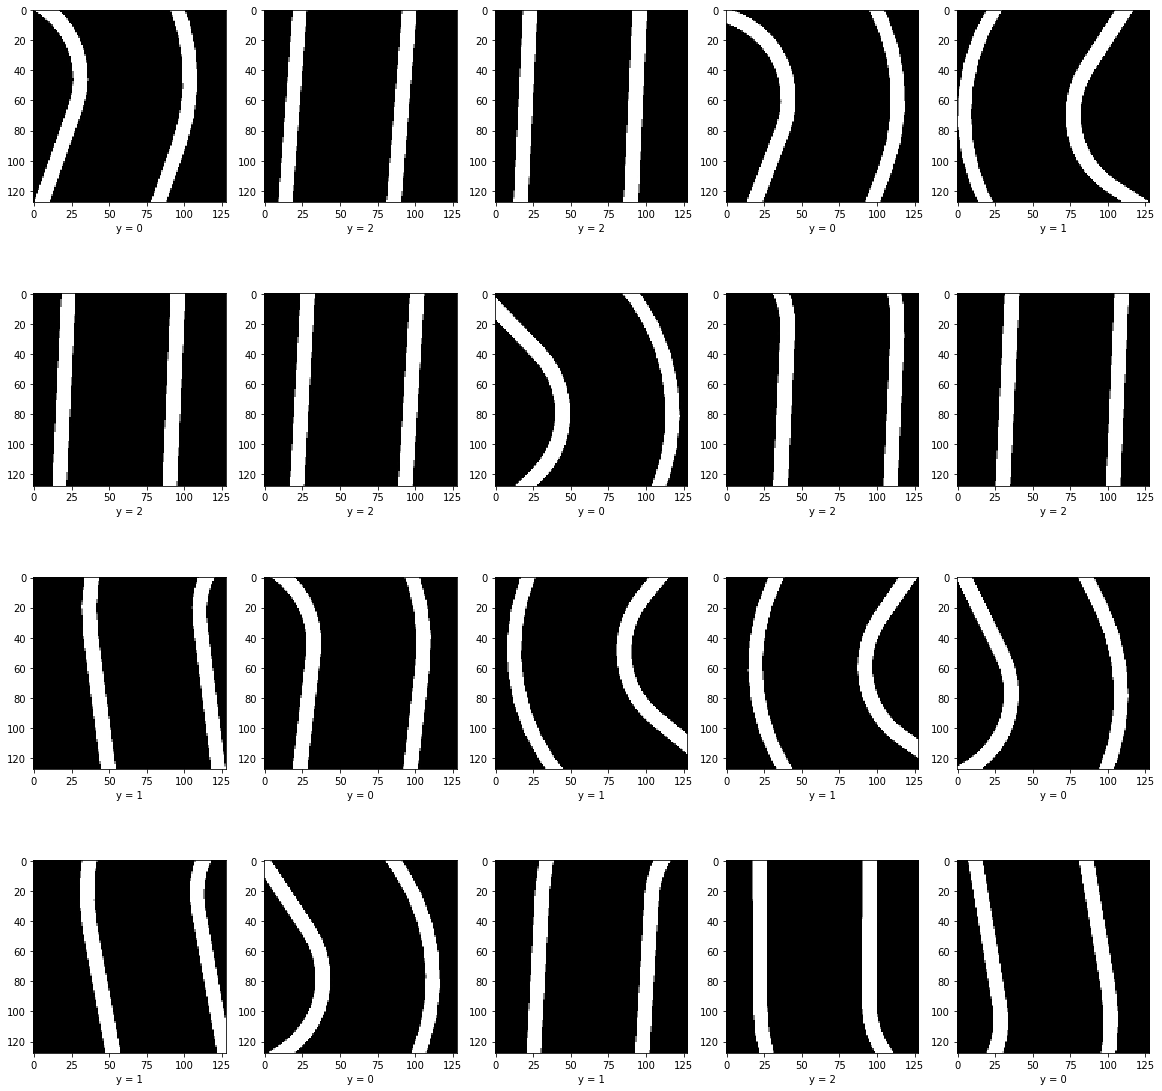

In [19]:
#plot some loaded data and its labels
fig=plt.figure(figsize=(20, 20))
columns = 5
rows = 4
for i in range(1, columns*rows +1):
    img = X_train_orig[i]
    fig.add_subplot(rows, columns, i)
    plt.xlabel("y = " + str(np.squeeze(Y_train_orig[:, i])))
    plt.imshow(img)
plt.show()

In [11]:
#defining the keras CNN model
def QuadNet_Model(input_shape):
    """
    Implementation of the QuadNet Model.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input placeholder as a tensor with shape input_shape. Input image!
    X_input = Input(input_shape, name = 'input')
    
    #CONV -> RELU Block applied to X
    X = Conv2D(32, (11, 11), strides = (4, 4), padding = 'same', name = 'conv1')(X_input)
    X = Activation('relu', name = 'relu1')(X)

    # Pooling Layer
    X = MaxPooling2D((2, 2), strides=(2, 2), name = 'pool1')(X)

    # CONV -> RELU Block applied to X
    X = Conv2D(64, (5, 5), strides = (1, 1), padding = 'same', name = 'conv2')(X)
    X = Activation('relu', name = 'relu2')(X)
    
    # Pooling Layer
    X = MaxPooling2D((2, 2), strides=(2, 2), name = 'pool2')(X)
    
    # CONV -> RELU Block applied to X
    X = Conv2D(128, (3, 3), strides = (1, 1), padding = 'same', name = 'conv3')(X)
    X = Activation('relu', name = 'relu3')(X)
    
    # Pooling Layer
    X = MaxPooling2D((2, 2), strides=(2, 2), name = 'pool3')(X)

    # CONV -> RELU Block applied to X
    X = Conv2D(256, (3, 3), strides = (1, 1), padding = 'same', name = 'conv4')(X)
    X = Activation('relu', name = 'relu4')(X)
    
    # Pooling Layer
    X = MaxPooling2D((2, 2), strides=(2, 2), name = 'pool4')(X)
    
    # CONV -> RELU Block applied to X
    X = Conv2D(128, (1, 1), strides = (1, 1), padding = 'same', name = 'conv5')(X)
    X = Activation('relu', name = 'relu5')(X)
    
    # Pooling Layer
    X = MaxPooling2D((2, 2), strides=(2, 2), name = 'pool5')(X)
    
    # CONV -> RELU Block applied to X
    X = Conv2D(64, (1, 1), strides = (1, 1), padding = 'same', name = 'conv6')(X)
    X = Activation('relu', name = 'relu6')(X)
    
    #FLATTEN X (convert X to a vector) + FULLYCONNECTED
    X = Flatten(name='fc1')(X)
    
    X = Dense(3, activation='softmax', name='fc2')(X)
    
    #Create model. This creates the keras model, later we use it to train/test the model
    model = Model(inputs = X_input, outputs = X, name='QuadNet')
    
    return model

In [12]:
QuadNet = QuadNet_Model(X_train.shape[1:])

In [13]:
#compile the model with optimizer, loss function and metrics
QuadNet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
QuadNet.summary()

Model: "QuadNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 128, 128, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        11648     
_________________________________________________________________
relu1 (Activation)           (None, 32, 32, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        51264     
_________________________________________________________________
relu2 (Activation)           (None, 16, 16, 64)        0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 8, 8, 64)          0   

In [16]:
#fit data to the network
QuadNet.fit(X_train, Y_train, validation_data = (X_val,Y_val), epochs = 1, batch_size = 30)

Train on 12483 samples, validate on 1560 samples
Epoch 1/1
12483/12483 [==============================] - 63s 5ms/step - loss: 0.0146 - accuracy: 0.9951 - val_loss: 0.0100 - val_accuracy: 0.9968


In [17]:
#evaluate the trained network with test set
preds = QuadNet.evaluate(X_test, Y_test)

print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1561/1561 [==============================] - 10s 6ms/step
/nLoss = 0.006175132067712987
Test Accuracy = 0.9980781674385071


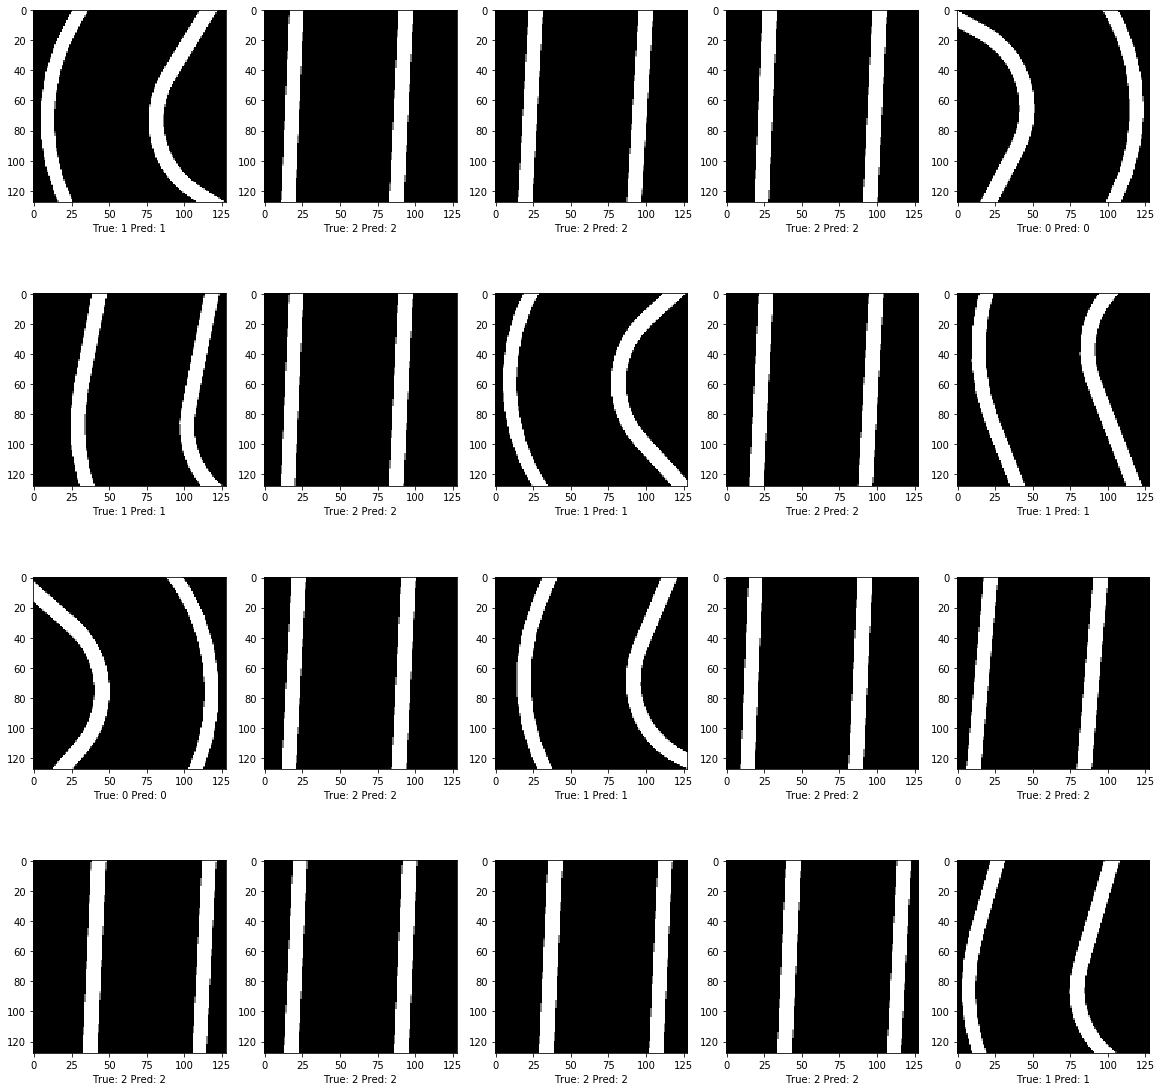

In [21]:
#plot some images along with their labels and predictions
fig=plt.figure(figsize=(20, 20))
columns = 5
rows = 4
for i in range(1, columns*rows +1):
    img = X_test_orig[i]
    x = X_test[i].reshape(1,int(512/4),int(512/4),3)
    y_pred = QuadNet.predict(x)
    cls_pred = np.argmax(y_pred,axis=1)
    fig.add_subplot(rows, columns, i)
    plt.xlabel("True: " + str(np.squeeze(Y_test_orig[:, i])) + " Pred: " + str(np.squeeze(cls_pred)))
    plt.imshow(img)
plt.show()

In [23]:
#Saving and loading model and weights in seperate files
from keras.models import model_from_json
from keras.models import load_model

In [30]:
#Serialize model to json format
model_json = QuadNet.to_json()
with open(PATH + '/Model/QuadNet.json', "w") as json_file:
    json_file.write(model_json)

In [39]:
#Serialize weights to HDF5
QuadNet.save_weights(PATH + '/Model/QuadWt.h5')
print("Saved model and its weights to disk")

Saved model and its weights to disk


In [40]:
#load json file from the disk and create model
json_model = open(PATH + '/Model/QuadNet.json', 'r')
loaded_json_model = json_model.read()
json_file.close()
loaded_model = model_from_json(loaded_json_model)

In [42]:
#load saved weights into the new loaded model
loaded_model.load_weights(PATH + '/Model/QuadWt.h5')
print("Loaded model and its weights from disk")

Loaded model and its weights from disk


In [43]:
#Saving model and weights in a single file
QuadNet.save(PATH + '/Model/Quad_Net_Wt.h5')
print("Saved model with weights to disk")

Saved model with weights to disk


In [44]:
#Loading model with weights
model = load_model(PATH + '/Model/Quad_Net_Wt.h5')
# summarize model
model.summary()

Model: "QuadNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 128, 128, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        11648     
_________________________________________________________________
relu1 (Activation)           (None, 32, 32, 32)        0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 16, 64)        51264     
_________________________________________________________________
relu2 (Activation)           (None, 16, 16, 64)        0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 8, 8, 64)          0   

In [45]:
#Test
preds = QuadNet.evaluate(X_test, Y_test)

print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1561/1561 [==============================] - 2s 1ms/step
Loss = 0.006175132067712987
Test Accuracy = 0.9980781674385071


In [53]:
#Test
image = X_test[1].reshape(1,int(512/4),int(512/4),3)
print(image.shape)
y_pred = QuadNet.predict(image)
cls_pred = np.argmax(y_pred,axis=1)
cls = np.squeeze(cls_pred)
print(cls)
print(cls.dtype)

(1, 128, 128, 3)
1
int64
